# Wasserstein GAN in Pytorch

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms, utils
%matplotlib inline

First, we, set up batch size, image size, and size of noise vector:

In [2]:
bs,sz,nz = 512,64,100
PATH_G = 'model3_g'
PATH_D = 'model3_d'

In [3]:
PATH = '/home/m20163692/data/lsun'
data = datasets.LSUN(db_path=PATH, classes=['church_outdoor_train'],
    transform=transforms.Compose([
        transforms.Scale(sz),
        transforms.CenterCrop(sz),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

Even parallel processing is handling automatically by torch-vision.

In [4]:
dataloader = torch.utils.data.DataLoader(data, bs, True, num_workers=8)
n = len(dataloader); n

247

In [5]:
next(iter(dataloader))[0].size()

torch.Size([512, 3, 64, 64])

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [6]:
def show(img, fs=(8,8)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')
    plt.show()

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [7]:
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from dcgan_bkup import DCGAN_D, DCGAN_G

Pytorch uses `module.apply()` for picking an initializer.

In [8]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
netG = DCGAN_G(sz, nz, 3, 64, 2, 1).cuda()
netG.apply(weights_init);

In [10]:
netD = DCGAN_D(sz, 3, 64, 2, 1).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [11]:
from torch import FloatTensor as FT

def Var(*params):
    return Variable(FT(*params).cuda())

def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [12]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [13]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [14]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [15]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [40]:
def train(niter, first=True):
    gen_iterations = 0
    save_flag = 1
    for epoch in range(niter):
        t0 = time()
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)
            # d_iters = 5

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                print(f'{i:04}/{gen_iterations:04}', end='\r')
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter)[0].cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
            if save_flag == -1:
                p_g = PATH_G + '_temp.pkl'
                p_d = PATH_D + '_temp.pkl'
            else:
                p_g = PATH_G + '.pkl'
                p_d = PATH_D + '.pkl'
            
            torch.save(netG.state_dict(), p_g)
            torch.save(netD.state_dict(), p_d)
            save_flag *= -1
            
        print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f (%.2fs)' % (
            epoch, niter, gen_iterations, n,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0], time() - t0))

In [ ]:
# train(200, True) # First run
train(10000, False)

## View

In [ ]:
# torch.save(netG.state_dict(), PATH_G + '.pkl')
# torch.save(netD.state_dict(), PATH_D + '.pkl')

In [80]:
# LOAD
netG.load_state_dict(torch.load(PATH_G + '.pkl'))
netD.load_state_dict(torch.load(PATH_D + '.pkl'))

In [81]:
fixed_noise = create_noise(bs)
fake = netG(fixed_noise[:64]).data.cpu()

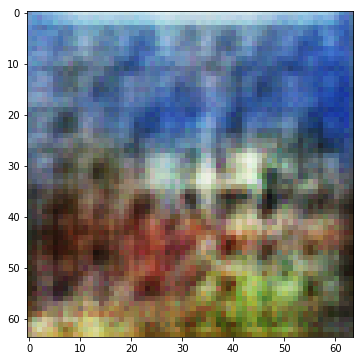

In [89]:
show(random.choice(fake), (6,6))

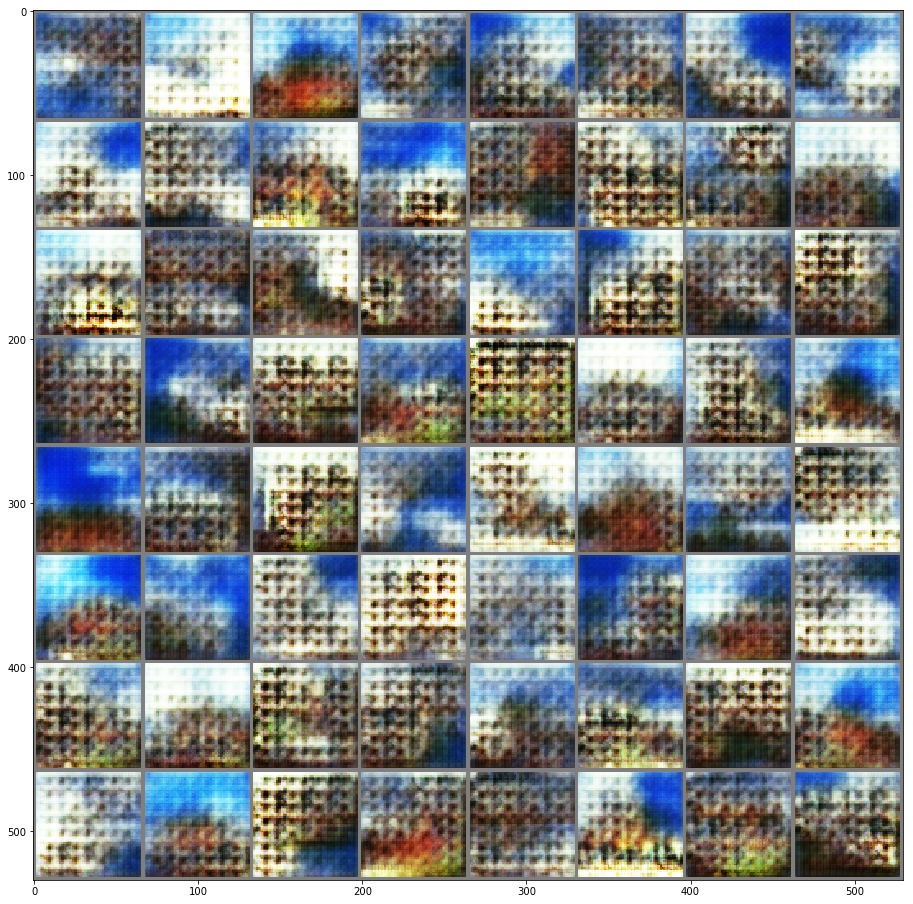

In [84]:
show(utils.make_grid(fake), (16,16))

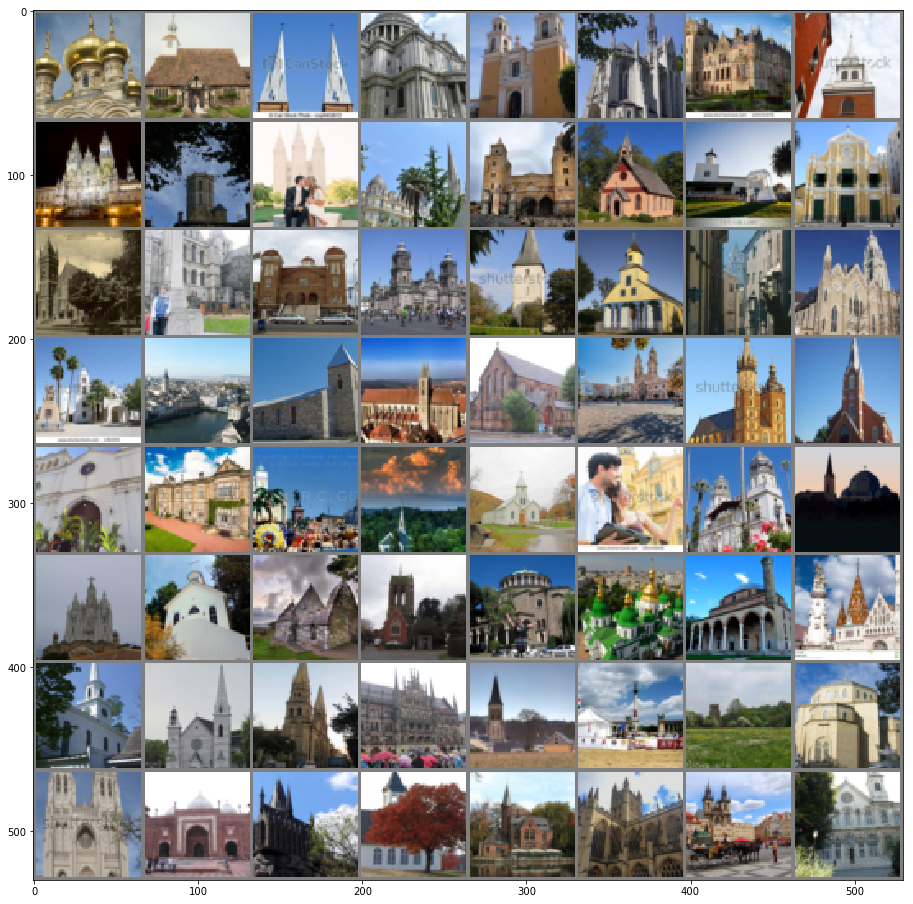

In [21]:
show(utils.make_grid(iter(dataloader).next()[0][:64]), (16,16))